In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61287 sha256=fe1b4b8f6bfe22a1457edeca8882da741487e7bf87718e6a13d1e522bf84109a
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31548 sha256=24bbfdc66732df086ec9b8f3b792c6392b6ad427e4c72d483d37f52f26d281c0
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84b9185196513ef2faf74a5a379b043a7
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py37_cu113_pyt1121/download.html
     |████████████████████████████████| 47.2 MB 1.3 MB/s 


In [2]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [3]:
!mkdir -p data
!wget -P data https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
!wget -P data https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj

--2022-11-10 17:14:36--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘data/teapot.obj’

teapot.obj          100%[===================>] 149.02K   538KB/s    in 0.3s    

2022-11-10 17:14:37 (538 KB/s) - ‘data/teapot.obj’ saved [152595/152595]

--2022-11-10 17:14:37--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow.obj’

cow.obj             100%[==================

In [4]:
from pytorch3d.structures import join_meshes_as_batch

# Set the cuda device 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Load the obj and ignore the textures and materials.
verts_teapot, faces_idx_teapot, _ = load_obj("./data/teapot.obj")
faces = faces_idx_teapot.verts_idx
verts_cow, faces_idx_cow, _ = load_obj("./data/cow.obj")
faces_cow = faces_idx_cow.verts_idx

# Initialize each vertex to be white in color.
verts_rgb_teapot = torch.ones_like(verts_teapot)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb_teapot.to(device))

verts_rgb_cow = torch.ones_like(verts_cow)[None]  # (1, V, 3)
textures_cow = TexturesVertex(verts_features=verts_rgb_cow.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts_teapot.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

cow_mesh = Meshes(
    verts=[verts_cow.to(device)],   
    faces=[faces_cow.to(device)], 
    textures=textures_cow
)

meshes = join_meshes_as_batch([teapot_mesh, cow_mesh])

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:546: UserWarning: Mtl file does not exist: ./data/cow.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [5]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

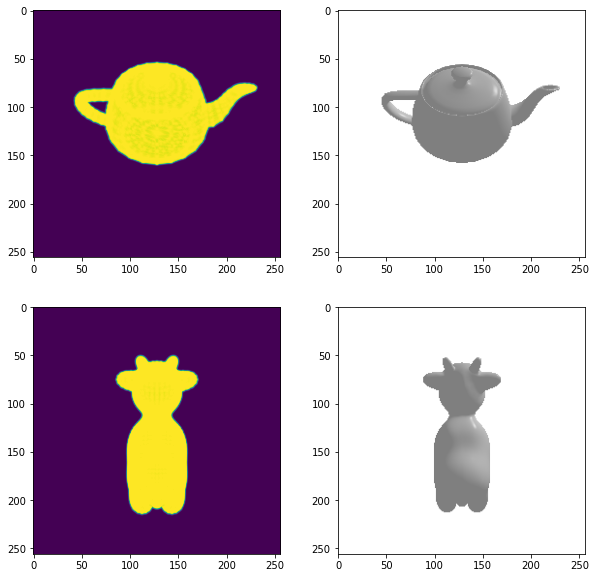

In [6]:
# Select the viewpoint using spherical angles  
distance = 3   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouettes = silhouette_renderer(meshes_world=meshes, R=R, T=T)
image_refs = phong_renderer(meshes_world=meshes, R=R, T=T)

silhouettes = silhouettes.cpu().numpy()
image_refs = image_refs.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(silhouettes.squeeze()[0, ..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(2, 2, 2)
plt.imshow(image_refs.squeeze()[0, ...,:3])
plt.grid(False)
plt.subplot(2, 2, 3)
plt.imshow(silhouettes.squeeze()[1, ..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(2, 2, 4)
plt.imshow(image_refs.squeeze()[1, ...,:3])
plt.grid(False)

In [35]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        # 처음부터 세개만 보라고 해둔 거 max(-1)에서 -1는 마지막 축 true = 그림이 있는 부분 false = 그림이 없는 부분
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
        torch.from_numpy(np.array([3.0, 0, 0.5], dtype=np.float32)).to(meshes.device))
        # 카메라 위치

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        #그래픽스 lookAt과 같음

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        # R = Rotation T = Translation
        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2) # 음수가 나오면 손실을 계산하기 애매하므로 제곱함 
        return loss, image

In [44]:
# Initialize a model using the renderer, mesh and reference image
models = Model(meshes=meshes, renderer=silhouette_renderer, image_ref=image_refs).to(device)
#obj 파일 열기

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(models.parameters(), lr=0.09)

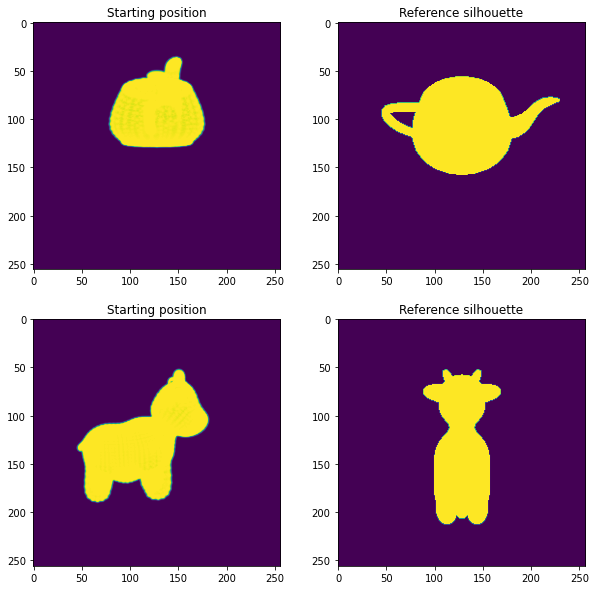

In [37]:
_, image_init = models()

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_init.detach().cpu().numpy()[0, ..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(2, 2, 2)
plt.imshow(models.image_ref.cpu().numpy()[0, ...])
plt.grid(False)
plt.title("Reference silhouette");

plt.subplot(2, 2, 3)
plt.imshow(image_init.detach().cpu().numpy()[1, ..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(2, 2, 4)
plt.imshow(models.image_ref.cpu().numpy()[1, ...])
plt.grid(False)
plt.title("Reference silhouette");

  0%|          | 0/200 [00:00<?, ?it/s]

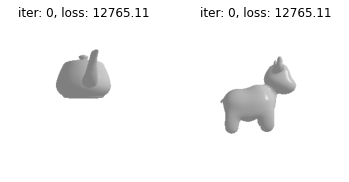

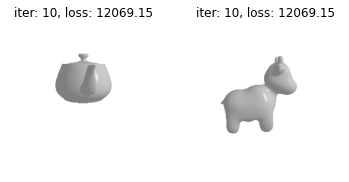

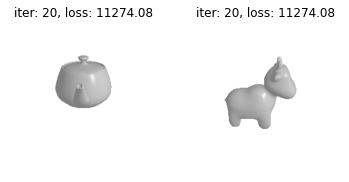

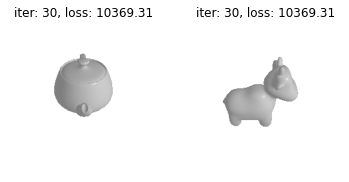

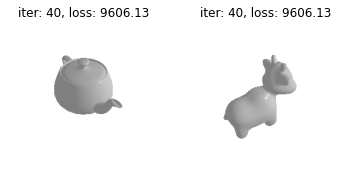

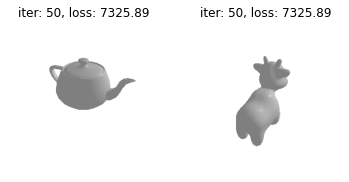

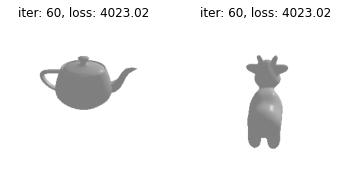

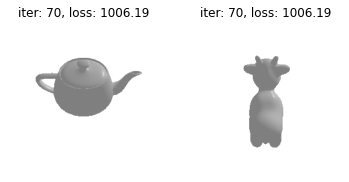

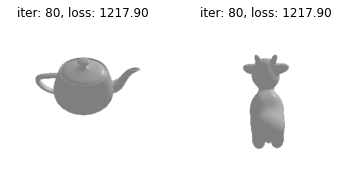

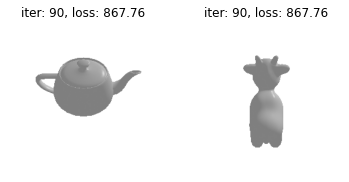

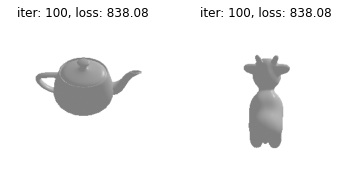

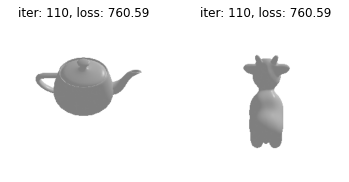

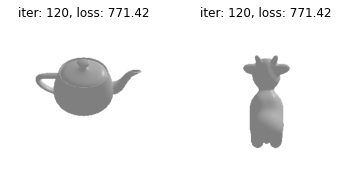

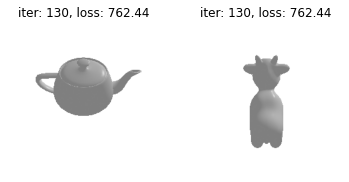

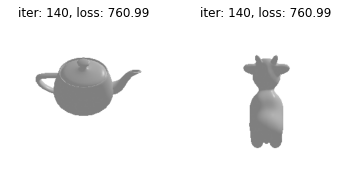

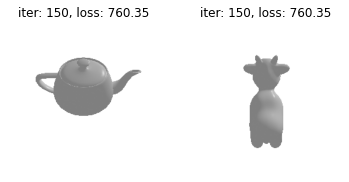

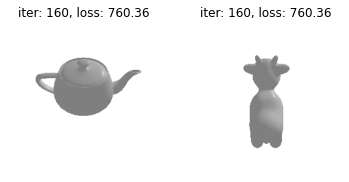

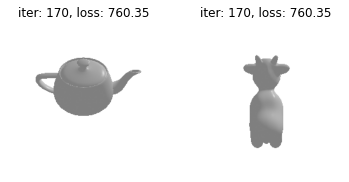

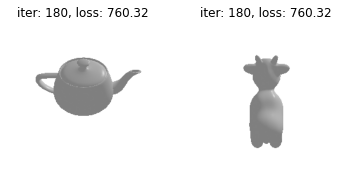

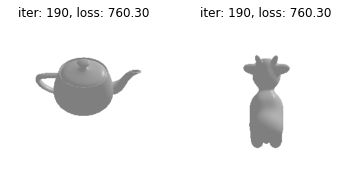

In [45]:
# We will save images periodically and compose them into a GIF.
filename_output1 = "./teapot_optimization_demo.gif"
filename_output2 = "./cou_optimization_demo.gif"

writer1 = imageio.get_writer(filename_output1, mode='I', duration=0.3)
writer2 = imageio.get_writer(filename_output2, mode='I', duration=0.3)

loop = tqdm(range(200)) # 진행되는 상황을 밑에 그래프로 찍어줌

for i in loop:
    optimizer.zero_grad()
    loss, _ = models()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break

    # Save outputs to create a GIF. 
    if i % 10 == 0:
        R = look_at_rotation(models.camera_position[None, :], device=models.device)
        T = -torch.bmm(R.transpose(1, 2), models.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image1 = phong_renderer(meshes_world=models.meshes[0].clone(), R=R, T=T)
        image1 = image1[0, ..., :3].detach().squeeze().cpu().numpy()
        image1 = img_as_ubyte(image1)
        writer1.append_data(image1)

        image2 = phong_renderer(meshes_world=models.meshes[1].clone(), R=R, T=T)
        image2 = image2[0, ..., :3].detach().squeeze().cpu().numpy()
        image2 = img_as_ubyte(image2)
        writer2.append_data(image2)

        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image1)
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(image2)
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")

writer1.close()
writer2.close()